# Project 2: Implementing a Simple Convolutional Neural Network (CNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Convolutional Neural Network (CNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- CIFAR-10: A dataset of 60,000 32x32 color images in 10 classes with 6,000 images per class.
- MNIST: A dataset of 70,000 28x28 grayscale images of handwritten digits (0-9).
- Fashion-MNIST: A dataset of 70,000 28x28 grayscale images of 10 different clothing caregories.


In [9]:
!nvidia-smi

!pip install torch torchvision

/bin/bash: line 1: nvidia-smi: command not found


###Data Preprocessing

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class AugmentedMNIST(torchvision.datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(28, padding=4),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
        ])

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode='L')

        if self.train:
            img = self.augment(img)
        img = np.array(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

trainset = AugmentedMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

print("Data loaded and transformed.")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3262217.14it/s]


Extracting ./data/AugmentedMNIST/raw/train-images-idx3-ubyte.gz to ./data/AugmentedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 639768.54it/s]


Extracting ./data/AugmentedMNIST/raw/train-labels-idx1-ubyte.gz to ./data/AugmentedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5588508.79it/s]


Extracting ./data/AugmentedMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/AugmentedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2685442.45it/s]

Extracting ./data/AugmentedMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/AugmentedMNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21910125.09it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 621562.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5650464.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1510627.93it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data loaded and transformed.


###Design the CNN Model

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN().to(device)
print("Model defined.")

Model defined.


###Define the Loss Function and Optimizer

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print("Loss function and optimizer defined.")

Loss function and optimizer defined.


###Train the Model

In [24]:
writer = SummaryWriter('runs/mnist_experiment')

epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            writer.add_scalar('training loss', running_loss / 200, epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1, Batch 200] loss: 2.302
[Epoch 1, Batch 400] loss: 2.298
[Epoch 1, Batch 600] loss: 2.294
[Epoch 1, Batch 800] loss: 2.287
[Epoch 2, Batch 200] loss: 2.248
[Epoch 2, Batch 400] loss: 2.137
[Epoch 2, Batch 600] loss: 1.876
[Epoch 2, Batch 800] loss: 1.689
Finished Training


###Evaluate the Model

In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

writer.add_scalar('accuracy', 100 * correct / total, epochs)

writer.close()

Accuracy of the network on the 10000 test images: 69.76 %


GroundTruth:      7     2     1     0
Predicted:      7     2     1     0


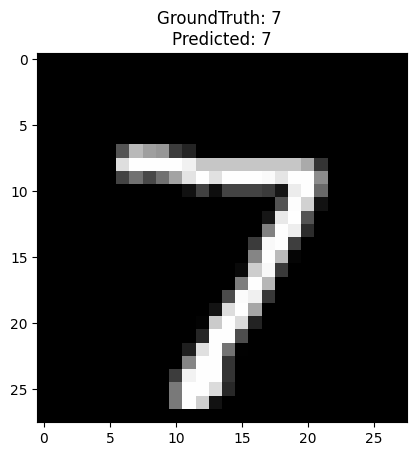

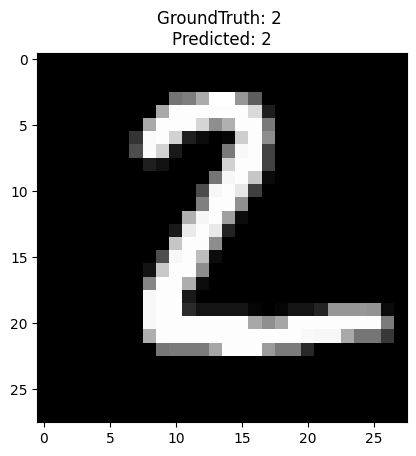

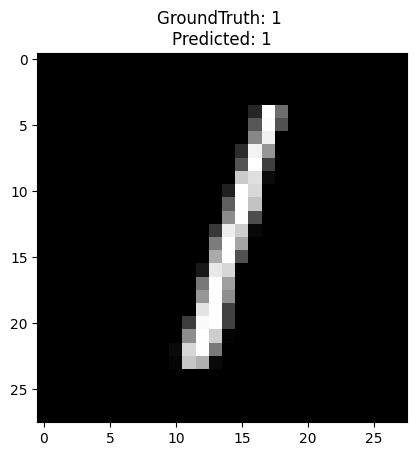

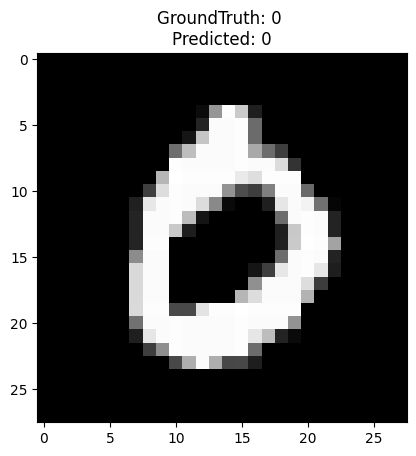

In [26]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    if title is not None:
        plt.title(title)
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

for i in range(4):
    imshow(images[i], f'GroundTruth: {classes[labels[i]]} \nPredicted: {classes[predicted[i]]}')

---
### Questions

1. What is a Convolutional Neural Network (CNN)? Describe its key components and how they differ from those in a fully connected neural network.

Answer:

A Convolutional Neural Network (CNN) is a specialized type of deep neural network designed for processing structured grid data, such as images. CNNs are particularly effective in tasks like image recognition, classification, and object detection. The key components of a CNN include convolutional layers, activation functions, pooling layers, fully connected layers, and dropout layers.


*KEY COMPONENTS*

**Convolutional layers** apply convolutional operations to the input, using learnable filters that slide over the input data to produce feature maps. This process helps capture spatial hierarchies and patterns in the data.

**Activation functions**, such as the Rectified Linear Unit (ReLU), are applied after each convolution operation to introduce non-linearity into the model.

**Pooling layers** perform down-sampling operations, reducing the spatial dimensions of the feature maps and thus the number of parameters and computations required.

**Fully connected layers**, or dense layers, follow the convolutional and pooling layers to perform high-level reasoning. Each neuron in a fully connected layer is connected to every neuron in the previous layer.

**Dropout layers** are used to prevent overfitting by randomly setting a fraction of input units to zero during training.


*DIFFERENCES FROM FULLY CONNECTED NETWORKS*

CNNs differ from fully connected networks in many ways. They use local connections in the convolutional layers rather than connecting every neuron to every other neuron. CNNs also leverage parameter sharing, where the same filter is used for different parts of the input, reducing the number of parameters. Additionally, CNNs are capable of capturing spatial hierarchies in images due to the convolution and pooling operations, which fully connected networks cannot do.

2. Explain the purpose of the convolution operation in a CNN. How does the use of different filter sizes affect the feature maps?


Answer:

The convolution operation is the core building block of a CNN. It involves sliding a filter, or kernel, over the input data and computing the dot product between the filter and local regions of the input. This operation produces a feature map that highlights specific patterns or features in the input data. The primary purpose of convolution is to extract relevant features, such as edges, textures, and shapes, from the input data while preserving spatial relationships between pixels. This process helps in learning spatial hierarchies, essential for tasks like image recognition.

The use of different filter sizes affects the feature maps in various ways. Small filters, such as 3x3, capture fine-grained details and local patterns. They are computationally efficient and allow for deeper networks with more layers. Large filters, such as 7x7, capture more global patterns and broader contextual information but are computationally expensive and may result in a larger number of parameters. Intermediate filters, like 5x5, provide a balance between capturing local and global features.

3. What is the purpose of a pooling layer in a CNN, and how does it contribute to the network’s performance?

Answer:

Pooling layers perform down-sampling operations on the feature maps produced by convolutional layers. The most common types are max pooling and average pooling. The primary purpose of pooling layers is dimensionality reduction, which decreases the spatial dimensions of the feature maps and, consequently, the number of parameters and computational load. Pooling also helps achieve translation invariance by summarizing the presence of features in regions of the input, making the network more robust to small translations and distortions. Pooling layers contribute to preventing overfitting by reducing the number of parameters which improves the network's performance by making it more efficient and better at generalizing to new data.

4. Why are activation functions important in CNNs? Compare the use of ReLU (Rectified Linear Unit) with other activation functions.

Answer:

Activation functions are important in CNNs because they introduce non-linearity, enabling the network to learn complex patterns and representations. Without activation functions, the network would behave as a linear model, regardless of its depth.

ReLU, defined as ReLU(x) = max(0, x), is widely used because it is simple and efficient, and it helps in propagating gradients effectively, addressing the vanishing gradient problem. Other activation functions include sigmoid and tanh. Sigmoid, defined as σ(x) = 1 / (1 + exp(-x)), can suffer from vanishing gradients, leading to slow convergence. Tanh, defined as tanh(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x)), also suffers from vanishing gradients but to a lesser extent than sigmoid. Leaky ReLU, defined as Leaky ReLU(x) = max(0.01x, x), allows a small gradient when the unit is not active, addressing the “dying ReLU” problem.

5. Describe the process of training a CNN. What are some common challenges faced during training?

Answer:

First, forward propagation is performed, where the input data is passed through the network to obtain output predictions. Next, the loss is calculated using a loss function that measures the difference between the predicted output and the ground truth. Backward propagation is then used to compute the gradients of the loss with respect to the network parameters. These gradients are used to update the network parameters using an optimization algorithm, such as Stochastic Gradient Descent (SGD) or Adam. This process is repeated for a specified number of epochs or until convergence.

Common challenges during training include overfitting, where the model performs well on training data but poorly on unseen data. This can be mitigated by using data augmentation, dropout, and regularization techniques. Another challenge is the vanishing or exploding gradient problem, where gradients become too small or too large, causing difficulties in training deep networks. Solutions include using activation functions like ReLU and techniques like batch normalization. Data scarcity, where limited training data can lead to poor generalization, can be addressed with data augmentation and transfer learning. Additionally, training deep CNNs requires significant computational power and memory, which can be addressed by using GPUs and efficient network architectures.

6. What are some common evaluation metrics used to assess the performance of a CNN on a classification task?

Answer:

Common evaluation metrics for assessing the performance of a CNN on a classification task include accuracy, precision, recall, the F1 score, and the confusion matrix. Accuracy is the proportion of correctly classified samples to the total number of samples. Precision is the proportion of true positive predictions to the total number of positive predictions, while recall is the proportion of true positive predictions to the total number of actual positives. The F1 score is the harmonic mean of precision and recall, providing a balanced measure. The confusion matrix shows the counts of true positives, false positives, true negatives, and false negatives, providing detailed insights into the model's performance.

7. How does data augmentation help improve the performance of a CNN? Provide examples of common data augmentation techniques.

Answer:

Data augmentation artificially increases the size and diversity of the training dataset by applying random transformations to the input data. It helps improve the model's ability to generalize and prevents overfitting by exposing the model to a wider variety of data. Common data augmentation techniques include horizontal and vertical flipping, rotation, cropping, translation, scaling, color jittering, and adding Gaussian noise. Horizontal and vertical flipping randomly flips the images. Rotation randomly rotates the images by a certain degree. Cropping involves randomly cropping a portion of the image and resizing it back to the original size. Translation shifts the image along the x or y axis, while scaling zooms in or out. Color jittering randomly changes the brightness, contrast, saturation, and hue of the image. Adding Gaussian noise introduces random noise to the image. By applying these transformations, the model learns to recognize patterns under various conditions, leading to better performance on unseen data.